In [1]:
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install textstat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 99.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
import pandas as pd
import json
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from textstat import flesch_reading_ease

In [3]:
## Load the data
train_df = pd.read_json("train.jsonl", lines=True)
val_df = pd.read_json("val.jsonl", lines=True)
print(train_df.head())


                                     id  \
0  ea468d03-1973-5039-86b2-ff225bb92c4e   
1  0d05f269-6d67-521d-9b5d-cc18f482c6c1   
2  c2ec79f3-da80-58f8-bef0-3e0ea7ab072f   
3  4ad37c58-0bb7-536b-997d-cfccabd0d094   
4  07747b0c-5051-5e0d-8096-b4d4ed8bd98e   

                                                text  \
0  Duke Ellington, a titan of jazz, revolutionize...   
1  I reflected on the shifting dynamics of media ...   
2  In F. Scott Fitzgerald's "The Great Gatsby," t...   
3  I still chuckle when I think about that time I...   
4  Yoga, originating in ancient India, encompasse...   

                          model  label   genre  
0          falcon3-10b-instruct      1  essays  
1                       o3-mini      1  essays  
2                        gpt-4o      1  essays  
3  deepseek-r1-distill-qwen-32b      1  essays  
4              gemini-2.0-flash      1  essays  


In [4]:
# Display basic info
print(train_df.info())
print("\nBasic Statistics:")
print(train_df.describe(include='all'))

# Check for missing values
print("\nMissing Values:")
print(train_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23707 entries, 0 to 23706
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      23707 non-null  object
 1   text    23707 non-null  object
 2   model   23707 non-null  object
 3   label   23707 non-null  int64 
 4   genre   23707 non-null  object
dtypes: int64(1), object(4)
memory usage: 926.2+ KB
None

Basic Statistics:
                                          id  \
count                                  23707   
unique                                 23707   
top     3c3b7167-cb78-5845-8583-294ae90e07a8   
freq                                       1   
mean                                     NaN   
std                                      NaN   
min                                      NaN   
25%                                      NaN   
50%                                      NaN   
75%                                      NaN   
max                                 

### Distribution of labels

<ipython-input-5-cc24f15b9029>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=train_df, palette='pastel')


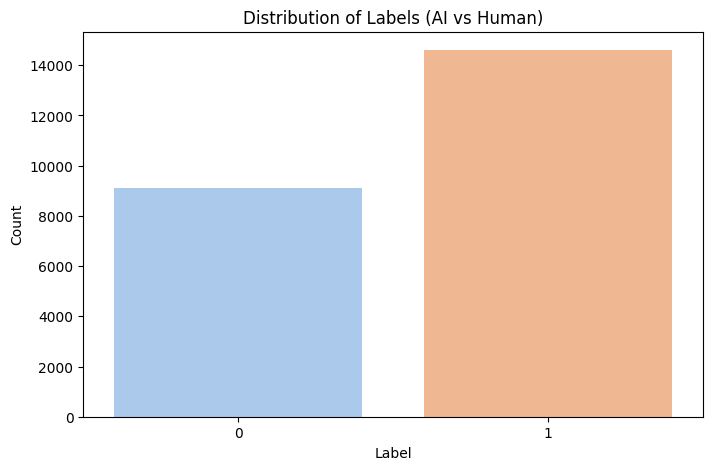

label
1    61.610495
0    38.389505
Name: proportion, dtype: float64


In [5]:
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=train_df, palette='pastel')
plt.title('Distribution of Labels (AI vs Human)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Percentage distribution
print(train_df['label'].value_counts(normalize=True) * 100)


### Distribution of Models

<ipython-input-6-a35b832191d1>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='model', data=train_df, order=train_df['model'].value_counts().index, palette='muted')


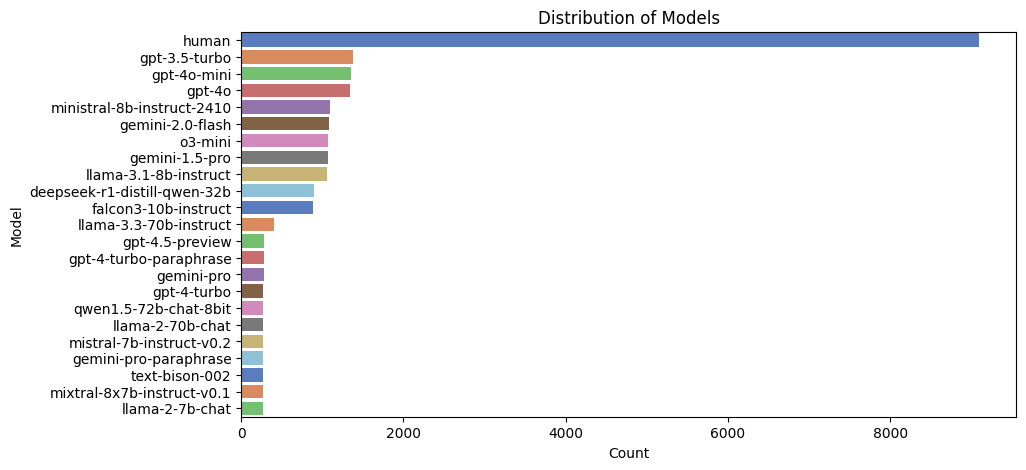

In [6]:
plt.figure(figsize=(10, 5))
sns.countplot(y='model', data=train_df, order=train_df['model'].value_counts().index, palette='muted')
plt.title('Distribution of Models')
plt.xlabel('Count')
plt.ylabel('Model')
plt.show()


### Genre Analysis

<ipython-input-7-81383fb3c755>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='genre', data=train_df, order=train_df['genre'].value_counts().index, palette='viridis')


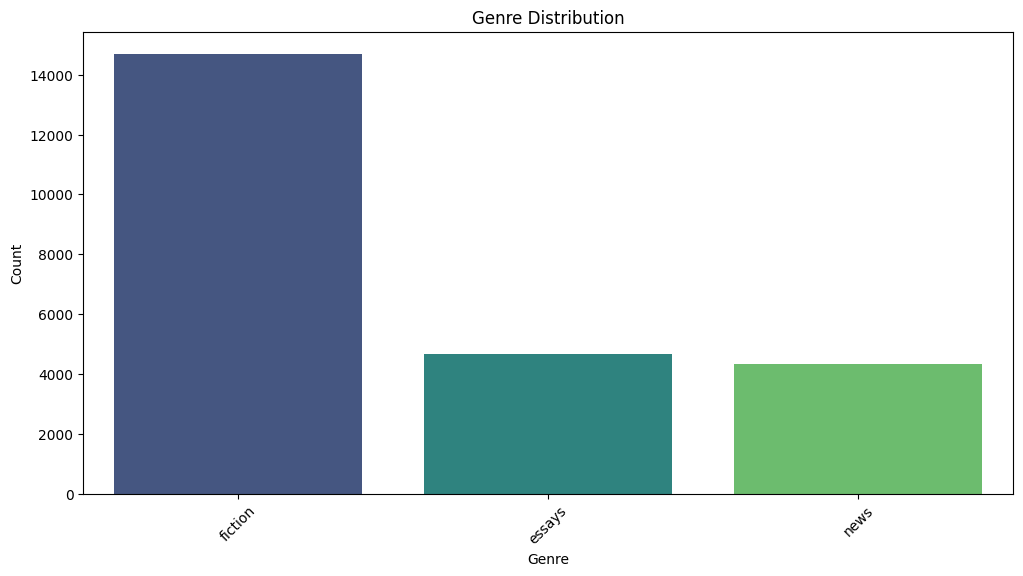

In [7]:
plt.figure(figsize=(12, 6))
sns.countplot(x='genre', data=train_df, order=train_df['genre'].value_counts().index, palette='viridis')
plt.title('Genre Distribution')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


### Text Length Distribution

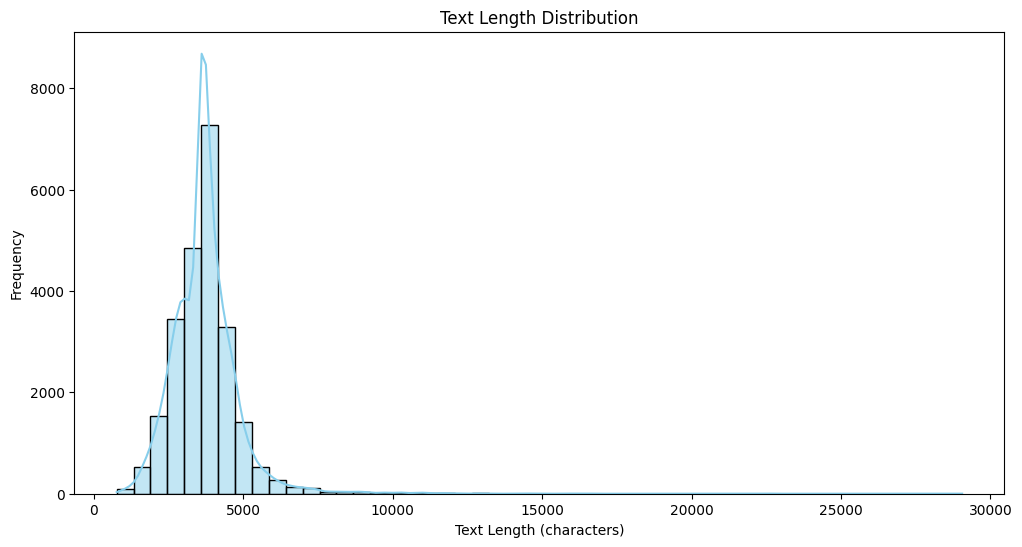

count    23707.000000
mean      3719.201249
std       1182.697844
min        761.000000
25%       3069.000000
50%       3648.000000
75%       4164.000000
max      29056.000000
Name: text_length, dtype: float64


In [8]:
# Add a new column with text lengths
train_df['text_length'] = train_df['text'].apply(len)

plt.figure(figsize=(12, 6))
sns.histplot(train_df['text_length'], bins=50, kde=True, color='skyblue')
plt.title('Text Length Distribution')
plt.xlabel('Text Length (characters)')
plt.ylabel('Frequency')
plt.show()

# Display basic statistics for text length
print(train_df['text_length'].describe())


### AI vs Human Text Length Comparison  

<ipython-input-9-af2d660edd81>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='text_length', data=train_df, palette='pastel')


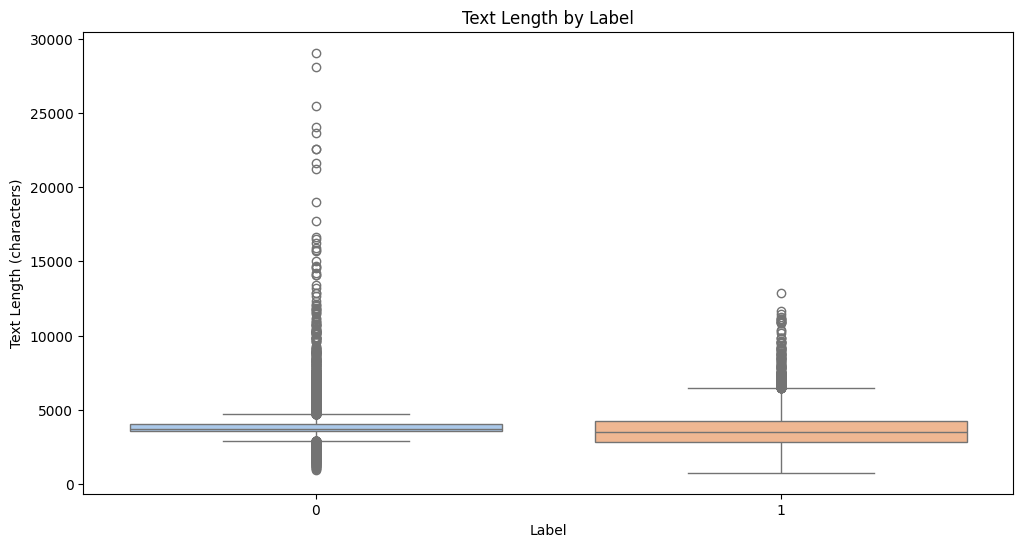

In [9]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='text_length', data=train_df, palette='pastel')
plt.title('Text Length by Label')
plt.xlabel('Label')
plt.ylabel('Text Length (characters)')
plt.show()


### word cloud visualization

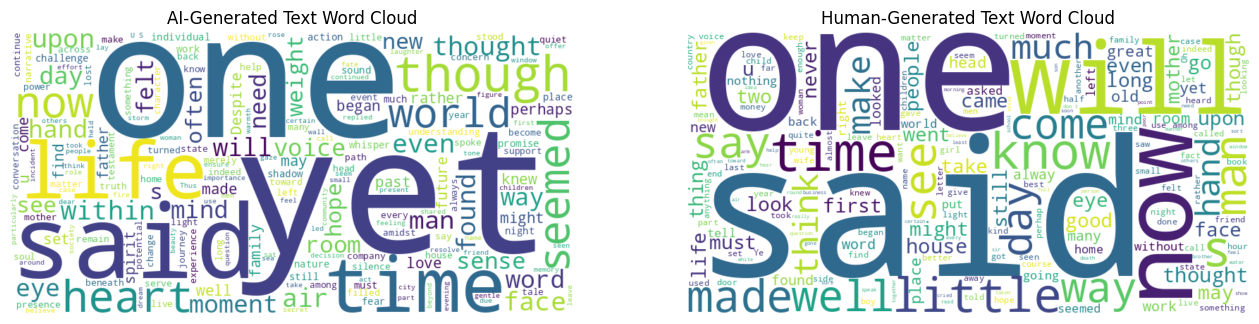

In [10]:
from wordcloud import WordCloud

# Generate Word Cloud for AI-generated text
ai_text = " ".join(train_df[train_df['label'] ==1]['text'])
wordcloud_ai = WordCloud(width=800, height=400, background_color='white').generate(ai_text)

# Generate Word Cloud for Human-generated text
human_text = " ".join(train_df[train_df['label'] == 0]['text'])
wordcloud_human = WordCloud(width=800, height=400, background_color='white').generate(human_text)

# Display side by side
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(wordcloud_ai, interpolation='bilinear')
ax[0].set_title('AI-Generated Text Word Cloud')
ax[0].axis('off')

ax[1].imshow(wordcloud_human, interpolation='bilinear')
ax[1].set_title('Human-Generated Text Word Cloud')
ax[1].axis('off')

plt.show()


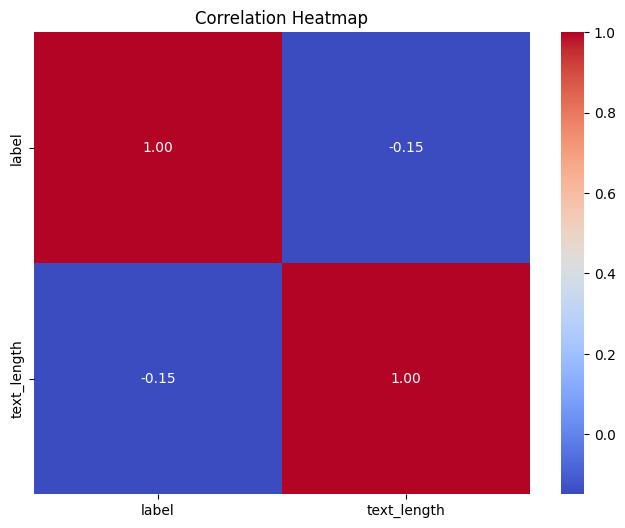

In [11]:
plt.figure(figsize=(8, 6))
sns.heatmap(train_df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


### Unique word counts by Label

<ipython-input-12-968cdc9e7e32>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='unique_words', data=train_df, palette='pastel')


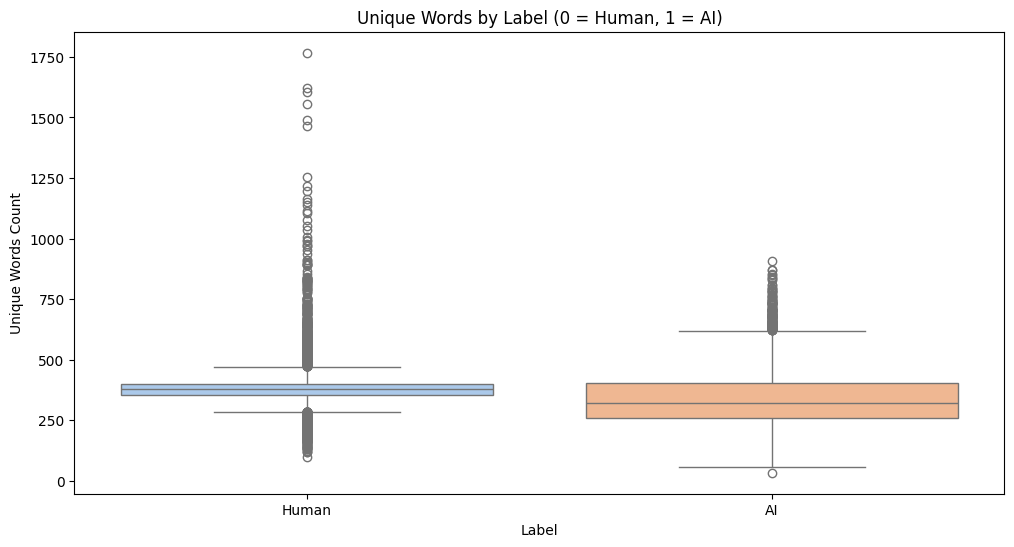


Average Unique Word Count by Label:
label
0    381.030107
1    332.886006
Name: unique_words, dtype: float64


In [12]:
# Function to count unique words in a text
def unique_word_count(text):
    words = text.split()
    return len(set(words))

# Add a column for unique word count
train_df['unique_words'] = train_df['text'].apply(unique_word_count)

# Visualization
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='unique_words', data=train_df, palette='pastel')
plt.title('Unique Words by Label (0 = Human, 1 = AI)')
plt.xlabel('Label')
plt.ylabel('Unique Words Count')
plt.xticks(ticks=[0, 1], labels=['Human', 'AI'])
plt.show()

# Display average unique word count
print("\nAverage Unique Word Count by Label:")
print(train_df.groupby('label')['unique_words'].mean())


### Phrase or N gram Frequency

In [14]:
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


<ipython-input-17-cd277e38769c>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='N-gram', data=ai_df, ax=ax1, palette='Blues')
<ipython-input-17-cd277e38769c>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='N-gram', data=human_df, ax=ax2, palette='Greens')


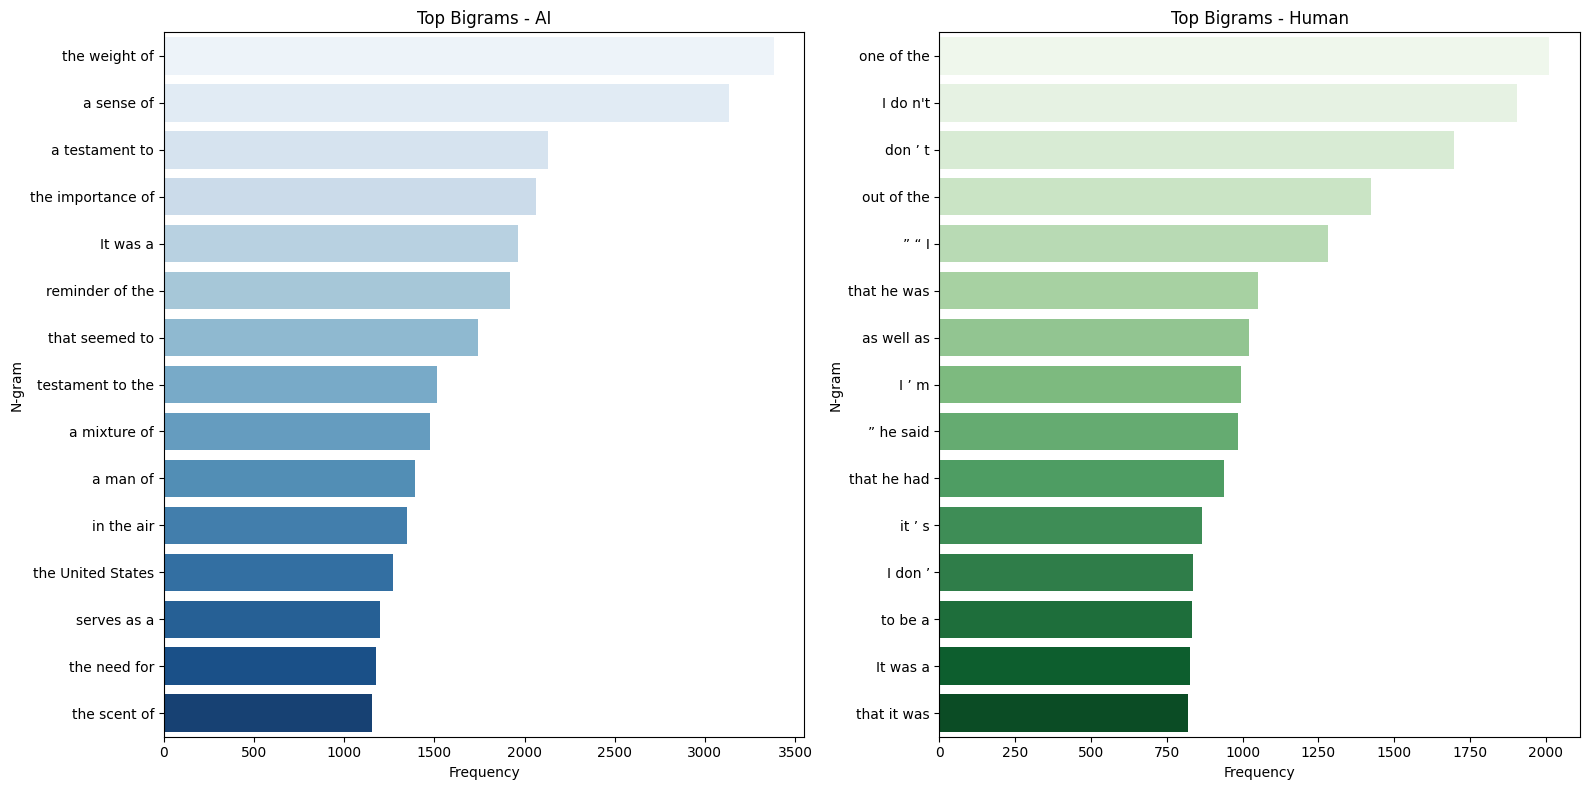

In [17]:
from textblob import TextBlob
from collections import Counter
import pandas as pd

# Function to extract n-grams using TextBlob
def get_ngrams_with_textblob(texts, n=2):
    ngram_list = []
    for text in texts:
        blob = TextBlob(text)
        ngrams = blob.ngrams(n)
        ngram_list.extend([" ".join(gram) for gram in ngrams])
    return Counter(ngram_list)

# AI and Human texts
ai_texts = train_df[train_df['label'] == 1]['text'].tolist()
human_texts = train_df[train_df['label'] == 0]['text'].tolist()

# Extracting N-gram frequencies
ai_ngrams = get_ngrams_with_textblob(ai_texts, n=3)
human_ngrams = get_ngrams_with_textblob(human_texts, n=3)

# Converting to DataFrame
ai_df = pd.DataFrame(ai_ngrams.items(), columns=['N-gram', 'Frequency']).sort_values('Frequency', ascending=False).head(15)
human_df = pd.DataFrame(human_ngrams.items(), columns=['N-gram', 'Frequency']).sort_values('Frequency', ascending=False).head(15)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

sns.barplot(x='Frequency', y='N-gram', data=ai_df, ax=ax1, palette='Blues')
ax1.set_title('Top Bigrams - AI')

sns.barplot(x='Frequency', y='N-gram', data=human_df, ax=ax2, palette='Greens')
ax2.set_title('Top Bigrams - Human')

plt.tight_layout()
plt.show()



### Readability score

<ipython-input-18-bc64a619cf65>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='readability', data=train_df, palette='pastel')


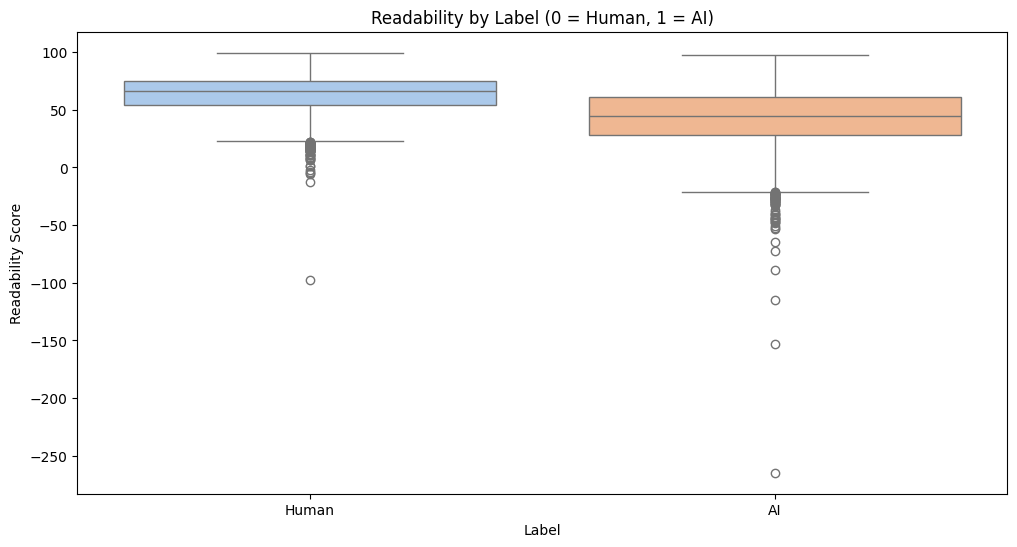


Average Readability by Label:
label
0    64.153758
1    43.181082
Name: readability, dtype: float64


In [18]:
from textstat import flesch_reading_ease

# Add readability scores
train_df['readability'] = train_df['text'].apply(flesch_reading_ease)

# Plot readability by label
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='readability', data=train_df, palette='pastel')
plt.title('Readability by Label (0 = Human, 1 = AI)')
plt.xlabel('Label')
plt.ylabel('Readability Score')
plt.xticks(ticks=[0, 1], labels=['Human', 'AI'])
plt.show()

# Display average readability
print("\nAverage Readability by Label:")
print(train_df.groupby('label')['readability'].mean())

### Lexical Diversity

<ipython-input-19-61f8c99f98db>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='lexical_diversity', data=train_df, palette='pastel')


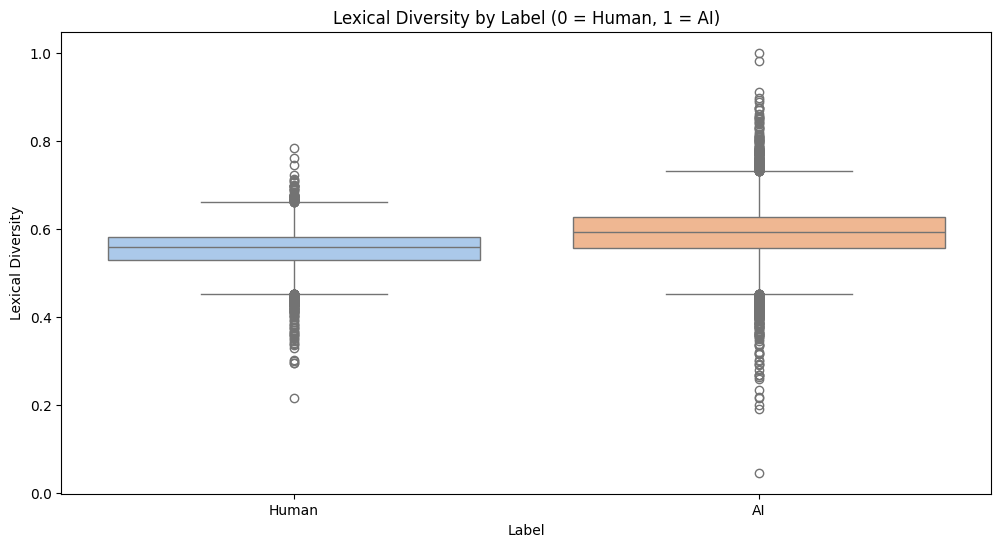


Average Lexical Diversity by Label:
label
0    0.554664
1    0.589907
Name: lexical_diversity, dtype: float64


In [19]:
# Function to calculate lexical diversity
def lexical_diversity(text):
    words = text.split()
    return len(set(words)) / len(words) if len(words) > 0 else 0

# Add a column for lexical diversity
train_df['lexical_diversity'] = train_df['text'].apply(lexical_diversity)

# Plotting
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='lexical_diversity', data=train_df, palette='pastel')
plt.title('Lexical Diversity by Label (0 = Human, 1 = AI)')
plt.xlabel('Label')
plt.ylabel('Lexical Diversity')
plt.xticks(ticks=[0, 1], labels=['Human', 'AI'])
plt.show()

# Display average lexical diversity
print("\nAverage Lexical Diversity by Label:")
print(train_df.groupby('label')['lexical_diversity'].mean())